In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
os.chdir(module_path)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import train as TR
from features import utils
from features import feature_combine, feature_clean
from features import data_clean
from evaluator import Evaluator
import gc

/home/peter/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
import config
config_file = 'test_config'
config_dict = getattr(config, config_file)
feature_list = config_dict['feature_list']
prop = utils.load_properties_data()

# Restoring the missing geo data from

https://www.kaggle.com/auroralht/restoring-the-missing-geo-data

In [12]:
prop.columns.tolist()

['parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'firep

Those columns contain Geographic Information :

|| latitude longitude

|| propertycountylandusecode propertylandusetypeid propertyzoningdesc

|| regionidcity regionidcounty regionidneighborhood regionidzip

|| censustractandblock rawcensustractandblock

In [4]:
geocolumns = [  'latitude', 'longitude'
                            ,'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc'
                            ,'regionidcity','regionidcounty', 'regionidneighborhood', 'regionidzip'
                            ,'censustractandblock', 'rawcensustractandblock', 'fips']

In [5]:
geoprop = prop[geocolumns]
del prop; gc.collect()

22

In [6]:
geoprop.columns.tolist()

['latitude',
 'longitude',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'censustractandblock',
 'rawcensustractandblock',
 'fips']

Find out the most completed column which could be use as a reference to impute the missing value

latitude                       11437
longitude                      11437
propertycountylandusecode      12277
propertylandusetypeid          11437
propertyzoningdesc           1006588
regionidcity                   62387
regionidcounty                 11437
regionidneighborhood         1810626
regionidzip                    13765
censustractandblock            75126
rawcensustractandblock         11437
dtype: int64

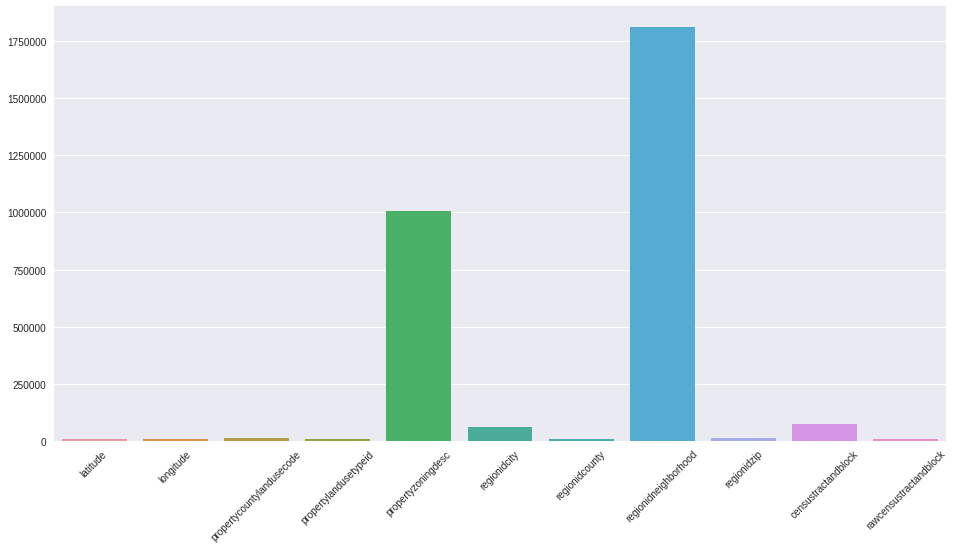

In [17]:
missingcount = geoprop.isnull().sum(axis=0)
plt.figure( figsize = (16,8) )
plot= sns.barplot( x = geocolumns,y = missingcount.values )
plt.setp( plot.get_xticklabels(), rotation = 45 )
missingcount

In [6]:
geoprop.dropna( axis = 0, subset = [ 'latitude', 'longitude' ], inplace = True )
geoprop.loc[:,'latitude'] = geoprop.loc[:,'latitude']/1e6
geoprop.loc[:,'longitude'] = geoprop.loc[:,'longitude']/1e6

    conda config --add channels conda-forge
    conda install basemap
    conda install -c conda-forge basemap-data-hires

need basemap 1.0.8

In [7]:
from mpl_toolkits.basemap import Basemap, cm

In [8]:
def create_basemap( llcrnrlat=20,urcrnrlat=50,llcrnrlon=-130,urcrnrlon=-60, figsize=(16,9) ):
    fig=plt.figure( figsize = figsize )
    Bm = Basemap( projection='merc', 
                llcrnrlat=llcrnrlat,urcrnrlat=urcrnrlat,
                llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,
                lat_ts=20,resolution='i' )
    # draw coastlines, state and country boundaries, edge of map.
    Bm.drawcoastlines(); 
    Bm.drawstates();
    Bm.drawcountries() 
    return Bm, fig    

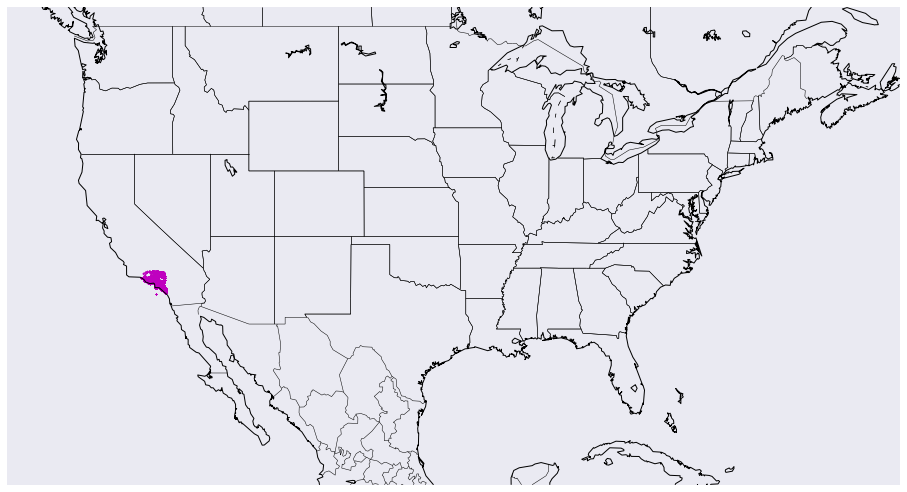

In [61]:
Bm, fig = create_basemap()
x,y = Bm( geoprop['longitude'].values, geoprop['latitude'].values)                           
Bm.scatter( x, y, marker = 'D',color = 'm', s = 1 )
plt.show()

In [9]:
maxlat = (geoprop['latitude']).max()
maxlon = (geoprop['longitude']).max()
minlat = (geoprop['latitude']).min()
minlon = (geoprop['longitude']).min()
print('maxlat {} minlat {} maxlon {} minlon {}'.format(maxlat, minlat, maxlon, minlon))

CAparms = { 'llcrnrlat' : minlat,
                     'urcrnrlat' : maxlat+0.2,
                     'llcrnrlon' : maxlon-2.5,
                     'urcrnrlon' :minlon+2.5 }

maxlat 34.819648 minlat 33.324388 maxlon -117.55432 minlon -119.475776


In [10]:
def view_map( df, target,see_known=True , see_unknown = True, ignorefirst = False, highlight = False):
    Bm, fig = create_basemap( **CAparms )
    # plot the known data
    if see_known:
        notmiss_df = df.loc[ df[target].notnull() ]
        groupby = notmiss_df.groupby(target)
        groups = [ groupby.get_group(g) for g in groupby.groups ]
        groups = groups[1:] if ignorefirst else groups 
        print( 'num groups:  ', len( groups ) )
        for group in groups:
            x,y = Bm( group['longitude'].values, group['latitude'].values )  
            if highlight:
                Bm.scatter( x, y,  marker = 'D', s = 1, color = 'red' )
            else:
                Bm.scatter( x, y,  marker = 'D', s = 1 )

    # plot the missing data
    if see_unknown:
        missing_target = df[target].isnull()
        if missing_target.any():
            print( '{} missing value at column: {}'.format( missing_target.sum(), target ) )
            missing = df.loc[ missing_target, ['latitude','longitude'] ]
            x,y = Bm( missing['longitude'].values, missing['latitude'].values )  
            Bm.scatter( x, y,  marker='D',s = 3, color = 'yellow', alpha = 0.1 )
        else:
            print('zero missing value at column: ', target )
        
    Bm.drawcounties( color='b', linewidth=0.3 )
    plt.show()

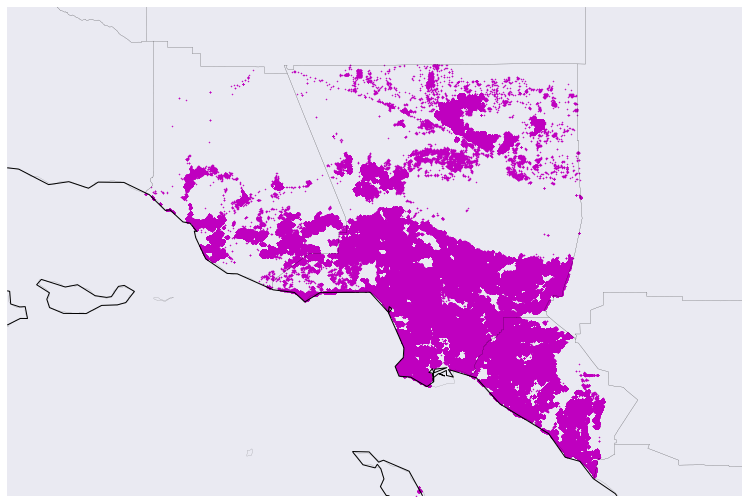

In [74]:
Bm, fig = create_basemap(**CAparms)
x,y = Bm( geoprop['longitude'].values, geoprop['latitude'].values)                           
Bm.scatter( x, y, marker = 'D',color = 'm', s = 1 )
Bm.drawcounties()
plt.show()

The yellow marker is the location of missing value

num groups:   186
50950 missing value at column: regionidcity


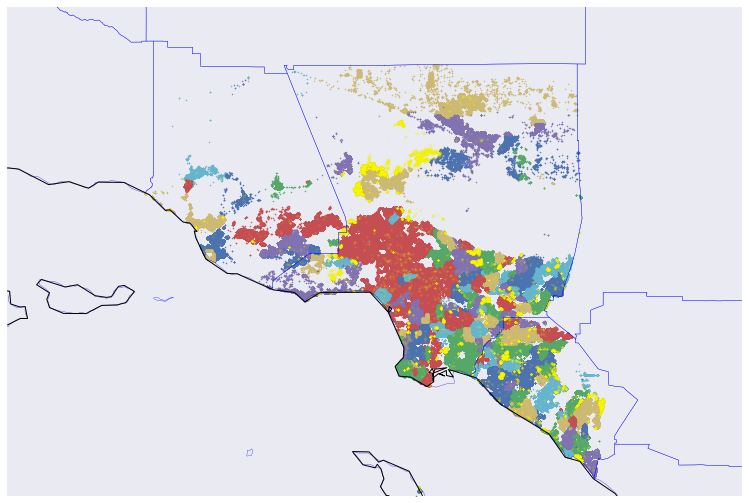

In [75]:
view_map( geoprop, 'regionidcity', ignorefirst = False )

In [9]:
from sklearn import neighbors
from sklearn.preprocessing import OneHotEncoder

def fillna_knn( df, base, target, fraction = 1, threshold = 10 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base # [regionidcity, lat, lon]
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print( 'fitting' )
    n_neighbors = 5
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    print( 'the shape of active features: ' ,enc.active_features_.shape )
    
    print( 'perdicting' )
    Z = clf.predict(df.loc[ miss, base  ])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        print( 'writing result to df_new' )
        df_new = df.copy()
        df_new.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        print( 'num of unperdictable data: ', numunperdicted )
        return df_new
    else:
        print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )

In [12]:
df_new=fillna_knn( df = geoprop,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcity', fraction = 0.15 )

fitting
the shape of active features:  (185,)
perdicting
writing result to df_new
num of unperdictable data:  72.0


num groups:   187
zero missing value at column:  regionidcity


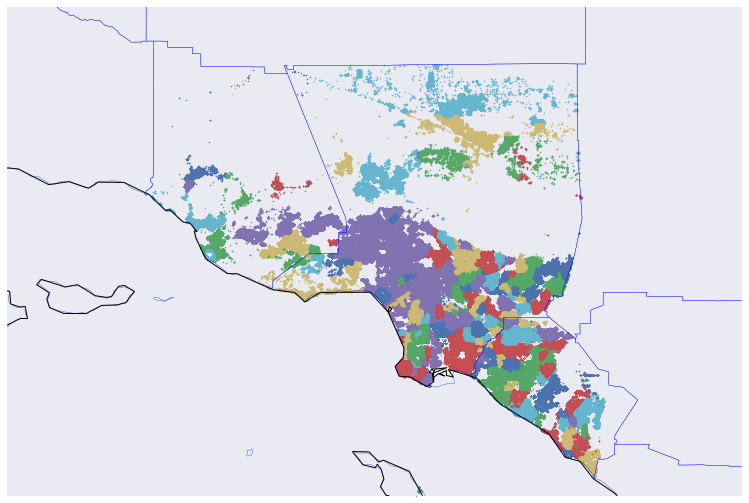

In [115]:
view_map( df_new, 'regionidcity', ignorefirst = False )

The first group (regionidcity=0) is also unpredicted

In [22]:
geoprop[geoprop['regionidcity']==0]

,latitude,longitude,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,censustractandblock,rawcensustractandblock


In [23]:
df_new[df_new['regionidcity']==0]

,latitude,longitude,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,censustractandblock,rawcensustractandblock
11256,33.725600,-118.081000,122,261.0,NaN,0.0,1286.0,NaN,96225.0,60590995061000,060590995.061000
25880,33.737788,-117.992768,122,261.0,NaN,0.0,1286.0,NaN,96973.0,60590997022020,060590997.022020
44009,33.896800,-118.376000,010C,266.0,HAM2*,0.0,3101.0,NaN,96107.0,60376023024017,060376023.024017
115456,33.790840,-117.906640,122,261.0,NaN,0.0,1286.0,NaN,97021.0,60590884031023,060590884.031023
127798,34.020960,-118.044368,0100,261.0,LCA15*,0.0,3101.0,NaN,96169.0,60375003001024,060375003.001024
199805,33.929816,-118.229320,0100,261.0,LCR2YY,0.0,3101.0,NaN,96040.0,60375404002016,060375404.002016
228479,34.134516,-118.092680,0101,261.0,LCR110,0.0,3101.0,NaN,96295.0,60374631022027,060374631.022027
229675,33.929448,-118.229232,0100,261.0,LCR2YY,0.0,3101.0,NaN,96040.0,60375404002017,060375404.002017
252133,33.896800,-118.376000,010C,266.0,HAM2*,0.0,3101.0,NaN,96107.0,60376023024017,060376023.024017
278859,33.725600,-118.081000,122,261.0,NaN,0.0,1286.0,NaN,96225.0,60590995061000,060590995.061000


In [153]:
groupscity = df_new.groupby('regionidcity')
groups =[ groupscity.get_group(x) for x in groupscity.groups ]

num groups:   1
zero missing value at column:  regionidcity


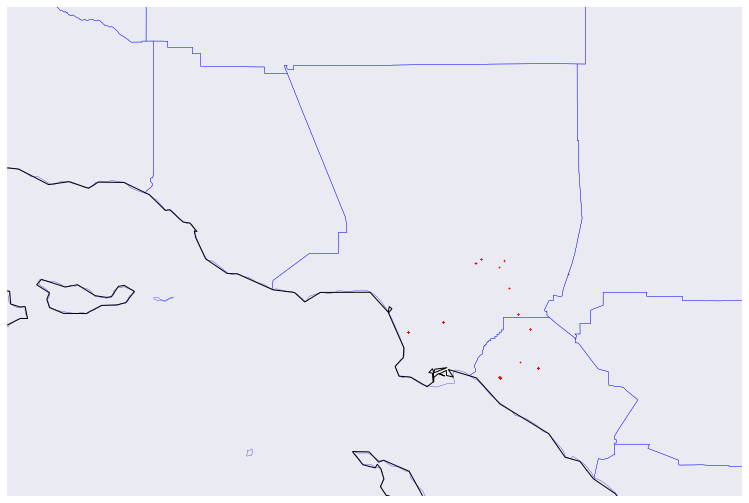

In [154]:
view_map(groups[0], 'regionidcity', highlight=True)

In [24]:
missingcount = df_new.isnull().sum(axis=0)
missingcount[missingcount>0]

propertycountylandusecode        840
propertyzoningdesc            995151
regionidneighborhood         1799189
regionidzip                     2328
censustractandblock            63689
dtype: int64

## Let's look atregionidneighborhood

1799189 missing value at column: regionidneighborhood


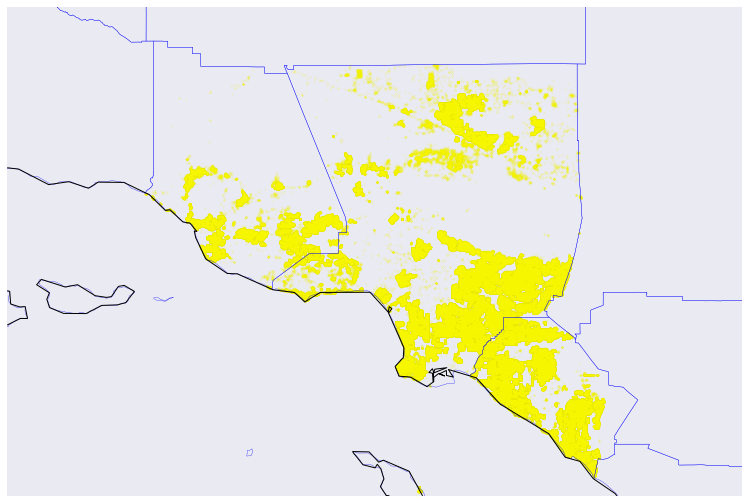

In [150]:
view_map( geoprop, 'regionidneighborhood',see_known=False, ignorefirst = False )

num groups:   528


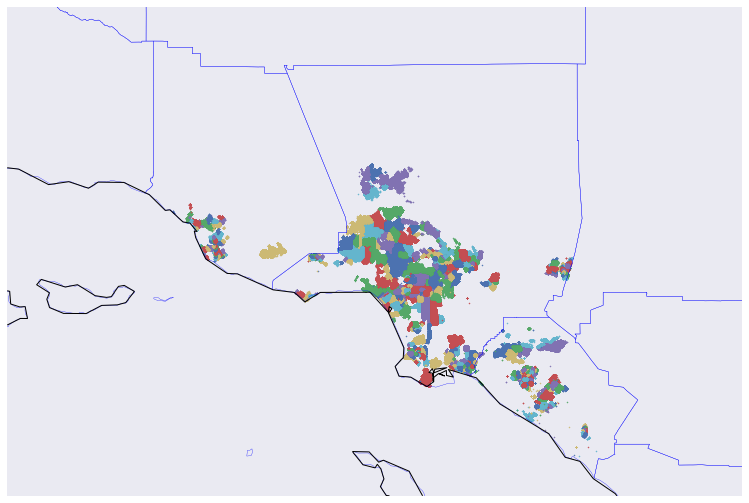

In [149]:
view_map( geoprop, 'regionidneighborhood',see_unknown=False, ignorefirst = False )

## It seems neighborhood is not a good place to crack on. Let's do regionidzip

In [14]:
df_new=fillna_knn( df = df_new,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidzip', fraction = 0.15 )

fitting
the shape of active features:  (392,)
perdicting
writing result to df_new
num of unperdictable data:  3.0


## Before

num groups:   405
2328 missing value at column: regionidzip


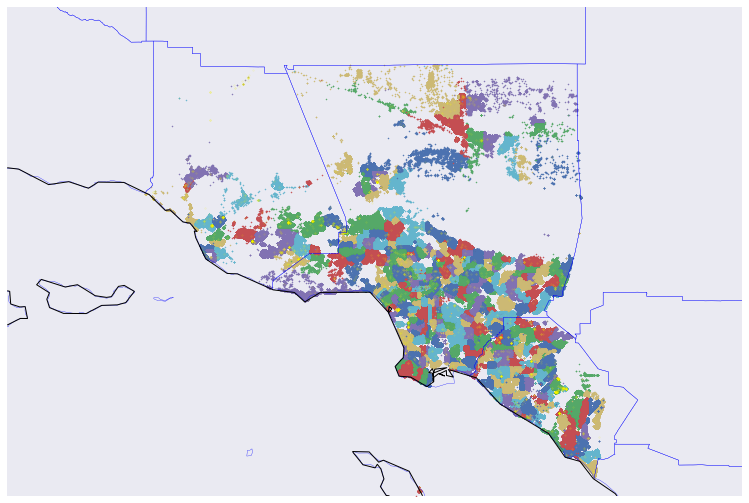

In [159]:
view_map( geoprop, 'regionidzip',see_unknown=True, ignorefirst = False )

## After

num groups:   406
zero missing value at column:  regionidzip


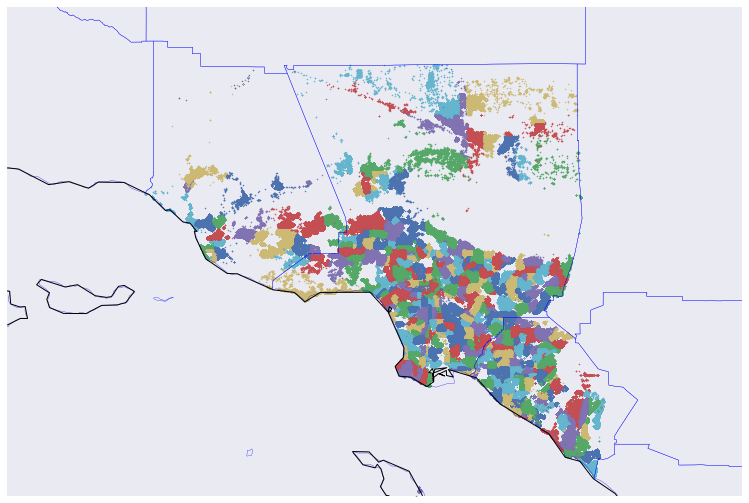

In [160]:
view_map( df_new, 'regionidzip',see_unknown=True, ignorefirst = False )

## Rawcensustractandblock does not miss information. Censustractandblock has some missing. Let's see if they are related.

In [35]:
df_new[['rawcensustractandblock','censustractandblock']]

,rawcensustractandblock,censustractandblock
0,060378002.0410,NaN
1,060378001.011002,NaN
2,060377030.012017,NaN
3,060371412.023001,NaN
4,060371232.052003,NaN
5,060371252.001000,NaN
6,060371437.00101,NaN
7,060373108.003004,NaN
8,060373101.003001,NaN
9,060373202.023005,NaN


## Not exactly the same..

In [15]:
def parse_census_block(df):
    df_from_raw = df.rawcensustractandblock.str.extract('(?P<fips_1>\d{5})(?P<census_1>\d{4})\.(?P<block_1>\d*)')
    df_from_csb = df.censustractandblock.str.extract('(?P<fips_2>\d{4})(?P<census_2>\d{4})(?P<block_2>\d*)')
    return pd.concat([df_from_raw, df_from_csb], axis=1).convert_objects(convert_numeric=True)
    

In [16]:
df_census = parse_census_block(df_new)

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until
/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


fips_1, census_1, block_1 from rawcensustractandblock

fips_2, census_2, block_2 from censustractandblock

In [17]:
df_census.corr()

,fips_1,census_1,block_1,fips_2,census_2,block_2
fips_1,1.000000,-0.576447,0.101730,0.999294,-0.577743,0.103397
census_1,-0.576447,1.000000,-0.143811,-0.577049,0.997411,-0.145828
block_1,0.101730,-0.143811,1.000000,0.103238,-0.147134,0.995883
fips_2,0.999294,-0.577049,0.103238,1.000000,-0.577488,0.102379
census_2,-0.577743,0.997411,-0.147134,-0.577488,1.000000,-0.146547
block_2,0.103397,-0.145828,0.995883,0.102379,-0.146547,1.000000


## Correlation 0.999, 0.997, 0.996

In [18]:
df_new = pd.concat([df_new, df_census], axis=1)

In [29]:
df_new[['fips', 'fips_1', 'fips_2']].corr()

,fips,fips_1,fips_2
fips,1.000000,0.999999,0.999295
fips_1,0.999999,1.000000,0.999294
fips_2,0.999295,0.999294,1.000000


In [21]:
df_new[df_new['fips']!=df_new['fips_1']]

,latitude,longitude,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,censustractandblock,rawcensustractandblock,fips,fips_1,census_1,block_1,fips_2,census_2,block_2
500928,33.949000,-117.962000,122,261.0,NaN,18875.0,1286.0,NaN,96186.0,60590011013013,060375001.002011,6059.0,6037,5001,2011,6059.0,11.0,13013.0
1214902,33.950828,-117.960496,122,261.0,NaN,18875.0,1286.0,NaN,96186.0,60590011013013,060375001.002000,6059.0,6037,5001,2000,6059.0,11.0,13013.0
1452897,33.948308,-117.963736,122,261.0,NaN,0.0,1286.0,NaN,96186.0,60590011013012,060375001.002011,6059.0,6037,5001,2011,6059.0,11.0,13012.0
2017907,33.947784,-117.963712,122,261.0,NaN,0.0,1286.0,NaN,96186.0,60590011013012,060375001.002012,6059.0,6037,5001,2012,6059.0,11.0,13012.0
2196293,33.948784,-117.963352,122,261.0,NaN,18875.0,1286.0,NaN,96186.0,60590011013013,060375001.002011,6059.0,6037,5001,2011,6059.0,11.0,13013.0
2908444,33.945452,-117.931752,0101,261.0,LHRA1*,18874.0,3101.0,NaN,96186.0,60375001001020,060590014.011013,6037.0,6059,14,11013,6037.0,5001.0,1020.0
2909591,33.955388,-117.957504,1,261.0,NaN,18875.0,1286.0,NaN,96186.0,60590011014011,060375002.011,6059.0,6037,5002,11,6059.0,11.0,14011.0


In [23]:
df_new[df_new['fips']!=df_new['fips_2']].dropna()

,latitude,longitude,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,censustractandblock,rawcensustractandblock,fips,fips_1,census_1,block_1,fips_2,census_2,block_2
59417,34.103392,-117.735912,012C,266.0,CLRS10000*,30908.0,3101.0,260611.0,96469.0,60710035071019,060374019.024,6037.0,6037,4019,24,6071.0,35.0,71019.0
74027,33.799000,-118.301000,010C,266.0,LAC1,12447.0,3101.0,38888.0,96210.0,60590762062013,060372933.021019,6037.0,6037,2933,21019,6059.0,762.0,62013.0
74030,33.799000,-118.301000,010C,266.0,LAC1,12447.0,3101.0,38888.0,96210.0,60590762062013,060372933.021019,6037.0,6037,2933,21019,6059.0,762.0,62013.0
163371,33.799000,-118.302000,010C,266.0,LAC1,12447.0,3101.0,38888.0,96210.0,60590762062013,060372933.021019,6037.0,6037,2933,21019,6059.0,762.0,62013.0
267471,33.799000,-118.301000,010C,266.0,LAC1,12447.0,3101.0,38888.0,96210.0,60590762062013,060372933.021019,6037.0,6037,2933,21019,6059.0,762.0,62013.0
386392,33.799000,-118.302000,010C,266.0,LAC1,12447.0,3101.0,38888.0,96210.0,60590762062013,060372933.021019,6037.0,6037,2933,21019,6059.0,762.0,62013.0
386398,33.799284,-118.300832,010C,266.0,LAC1,12447.0,3101.0,38888.0,96210.0,60590762062013,060372933.021019,6037.0,6037,2933,21019,6059.0,762.0,62013.0
431188,33.799284,-118.300832,010C,266.0,LAC1,12447.0,3101.0,38888.0,96210.0,60590762062013,060372933.021019,6037.0,6037,2933,21019,6059.0,762.0,62013.0
460765,33.799200,-118.302000,010C,266.0,LAC1,12447.0,3101.0,38888.0,96210.0,60590762062013,060372933.021019,6037.0,6037,2933,21019,6059.0,762.0,62013.0
520227,33.799300,-118.301000,010C,266.0,LAC1,12447.0,3101.0,38888.0,96210.0,60590762062013,060372933.021019,6037.0,6037,2933,21019,6059.0,762.0,62013.0


## Seems like fips_1 and fips_2 does not provide too much information

num groups:   3
zero missing value at column:  fips_1


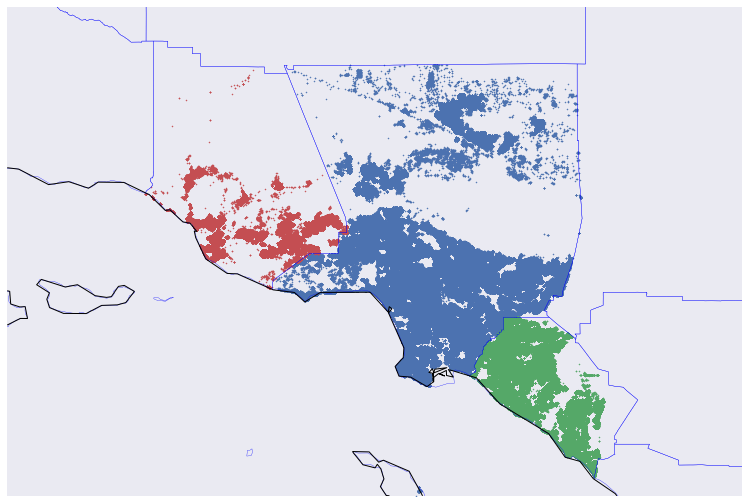

In [24]:
view_map( df_new, 'fips_1',see_unknown=True, ignorefirst = False )

In [27]:
df_new['regionidcounty'].value_counts()

3101.0    2009362
1286.0     741565
2061.0     222853
Name: regionidcounty, dtype: int64

In [28]:
df_new['fips'].value_counts()

6037.0    2009362
6059.0     741565
6111.0     222853
Name: fips, dtype: int64

In [30]:
df_test = df_new['regionidcounty'].map({3101: 6037, 1286: 6059, 2061: 6111})

In [34]:
df_new[['fips', 'fips_1', 'fips_2']].corrwith(df_test)

fips      1.000000
fips_1    0.999999
fips_2    0.999295
dtype: float64

## Fips==regionidcounty. basically useless

In [35]:
del df_test;
del df_census;
gc.collect()

17008

In [50]:
df_new['census_2'].value_counts()

320.0     70434
626.0     52724
423.0     45876
992.0     45398
524.0     35858
9200.0    30838
218.0     30296
525.0     29193
219.0     23117
4033.0    21927
9203.0    20476
9201.0    17395
15.0      15695
994.0     15602
1101.0    15447
1100.0    15389
5545.0    15222
75.0      15080
9107.0    14620
421.0     14255
117.0     14030
758.0     13222
8003.0    12611
9102.0    11873
9010.0    10502
756.0     10485
993.0     10288
76.0      10213
59.0      10203
4086.0    10196
          ...  
2242.0      118
7019.0      117
2774.0      112
2095.0      100
2240.0       85
1275.0       74
1902.0       74
1.0          60
2247.0       56
2088.0       53
1904.0       51
2151.0       43
2093.0       37
2089.0       36
9301.0       31
2145.0       29
466.0        18
5755.0       18
7011.0       17
2362.0       15
5716.0        9
406.0         9
2092.0        5
2063.0        5
35.0          4
5324.0        3
7029.0        2
189.0         1
438.0         1
488.0         1
Name: census_2, Length: 

In [47]:
df_new.groupby(['fips', 'census_2']).count()

latitude  longitude  propertycountylandusecode  \
fips   census_2                                                   
6037.0 3.0              1          1                          1   
       4.0              1          1                          1   
       10.0             1          1                          1   
       12.0             1          1                          1   
       15.0             3          3                          3   
       18.0            40         40                         40   
       20.0             1          1                          1   
       29.0             1          1                          1   
       35.0             4          4                          4   
       38.0             1          1                          1   
       59.0             1          1                          1   
       117.0            1          1                          1   
       406.0            6          6                          6   
       466.0           18         18                         18   
       524.0            1          1                          1   
       626.0            1          1                          1   
       740.0            2          2                          2   
       748.0            1          1                          1   
       750.0            1          1                          1   
       752.0            1          1                          1   
       762.0           45         45                         45   
       865.0           41         41                         41   
       868.0           10         10                         10   
       883.0            2          2                          2   
       992.0            1          1                          1   
       1011.0        2510       2510                       2510   
       1012.0        1318       1318                       1318   
       1013.0        1531       1531                       1531   
       1014.0        1270       1270                       1270   
       1021.0        3467       3467                       3467   
...                   ...        ...                        ...   
6111.0 65.0           951        951                        951   
       66.0          1339       1339                       1339   
       67.0           963        963                        963   
       68.0          1127       1127                       1127   
       69.0          1137       1137                       1137   
       70.0           560        560                        560   
       71.0          1461       1461                       1461   
       72.0          2873       2873                       2873   
       73.0           872        872                        872   
       74.0          7566       7566                       7566   
       75.0         15080      15080                      15080   
       76.0         10213      10213                      10213   
       77.0          1772       1772                       1772   
       78.0           633        633                        633   
       79.0          4610       4610                       4610   
       80.0          4462       4462                       4462   
       81.0          1099       1099                       1099   
       82.0          2740       2740                       2740   
       83.0          6756       6756                       6756   
       84.0          3204       3204                       3204   
       85.0          2487       2487                       2487   
       86.0           915        915                        915   
       87.0           936        936                        936   
       88.0          1347       1347                       1347   
       89.0           698        698                        698   
       91.0           364        364                        364   
       1091.0           4          4                          4 

In [48]:
df_new.groupby(['fips', 'census_2', 'block_2']).count()

latitude  longitude  propertycountylandusecode  \
fips   census_2 block_2                                                    
6037.0 3.0      34014.0          1          1                          1   
       4.0      41016.0          1          1                          1   
       10.0     23000.0          1          1                          1   
       12.0     22009.0          1          1                          1   
       15.0     32007.0          3          3                          3   
       18.0     103000.0        39         39                         39   
                103001.0         1          1                          1   
       20.0     342002.0         1          1                          1   
       29.0     11016.0          1          1                          1   
       35.0     71019.0          4          4                          4   
       38.0     43002.0          1          1                          1   
       59.0     61001.0          1          1                          1   
       117.0    153007.0         1          1                          1   
       406.0    133014.0         6          6                          6   
       466.0    22004.0          2          2                          2   
                22009.0         16         16                         16   
       524.0    204016.0         1          1                          1   
       626.0    141000.0         1          1                          1   
       740.0    44000.0          2          2                          2   
       748.0    23014.0          1          1                          1   
       750.0    32003.0          1          1                          1   
       752.0    22017.0          1          1                          1   
       762.0    62013.0         45         45                         45   
       865.0    11001.0         20         20                         20   
                11002.0         21         21                         21   
       868.0    11010.0          7          7                          7   
                11032.0          3          3                          3   
       883.0    12012.0          2          2                          2   
       992.0    512008.0         1          1                          1   
       1011.0   101000.0        40         40                         40   
...                            ...        ...                        ...   
6111.0 91.0     1008.0           7          7                          7   
                1009.0           7          7                          7   
                1010.0           7          7                          7   
                1011.0           7          7                          7   
                1012.0           7          7                          7   
                1013.0           5          5                          5   
                1014.0           6          6                          6   
                1015.0           6          6                          6   
                1016.0           5          5                          5   
                1017.0           6          6                          6   
                1018.0           6          6                          6   
                1019.0           6          6                          6   
                1020.0          12         12                         12   
                2002.0           2          2                          2   
                2003.0           1          1                          1   
                2013.0           1          1                          1   
                2017.0          84         84                         84   
                2020.0           1          1                          1   
                2025.0           1          1                          1   
                2027.0           2          2                          2  

In [49]:
df_new['block_2'].value_counts()

12000.0     15849
2000.0      15389
2001.0      15229
21000.0     14948
22000.0     14917
1003.0      14469
2002.0      14343
1001.0      14230
22001.0     13765
1002.0      13695
1000.0      13646
2003.0      13563
1005.0      13544
11000.0     13342
21002.0     13327
22002.0     13307
2004.0      12956
3001.0      12945
1004.0      12825
2005.0      12758
21003.0     12615
21004.0     12562
3000.0      12514
12001.0     12250
1006.0      12230
12002.0     12100
21001.0     11856
22003.0     11848
11005.0     11822
11001.0     11717
            ...  
81046.0         1
12149.0         1
81043.0         1
12148.0         1
21644.0         1
151164.0        1
151151.0        1
201068.0        1
91667.0         1
102125.0        1
19001.0         1
91678.0         1
82057.0         1
12224.0         1
21522.0         1
12221.0         1
12220.0         1
21551.0         1
12214.0         1
201026.0        1
201039.0        1
91668.0         1
12200.0         1
12194.0         1
21554.0   

num groups:   1420
zero missing value at column:  census_1


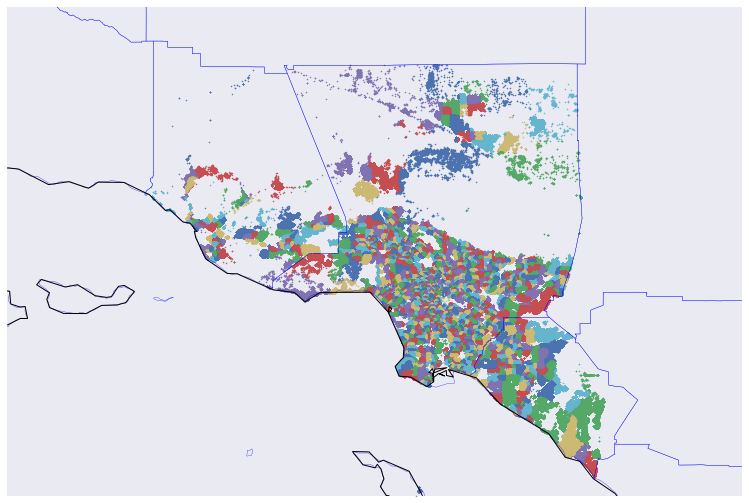

In [51]:
view_map( df_new, 'census_1',see_unknown=True, ignorefirst = False )

## So census and block themselves probably doesn't mean anything. Combining them gives out blocks smaller than neighborhood. However it is almost filled, as opposed to neighborhood!


## The generated features:

fips_census_1

fips_census_2 (opt)

fips_census_1_block_1 (same as rawcensustractblock without the dot)

fips_census_2_block_2 (same as censustractblock, opt)

In [52]:
def parse_census_block_2(df):
    df2 = df.rawcensustractandblock.str.extract('(?P<fips_census_1>\d{9})\.(?P<block_1>\d*)')
    df2['fips_census_block'] = df2['fips_census_1'] + df2['block_1']
    del df2['block_1']
    return df2

In [54]:
df_census=parse_census_block_2(df_new)

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [55]:
df_census

,fips_census_1,fips_census_block
0,060378002,0603780020410
1,060378001,060378001011002
2,060377030,060377030012017
3,060371412,060371412023001
4,060371232,060371232052003
5,060371252,060371252001000
6,060371437,06037143700101
7,060373108,060373108003004
8,060373101,060373101003001
9,060373202,060373202023005


In [56]:
missingcount = df_new.isnull().sum(axis=0)
missingcount[missingcount>0]

propertycountylandusecode        840
propertyzoningdesc            995151
regionidneighborhood         1799189
censustractandblock            63689
fips_2                         63692
census_2                       63692
block_2                        63692
dtype: int64

In [59]:
df_new.drop(['fips_2','census_2', 'block_2'],axis=1)

,latitude,longitude,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,censustractandblock,rawcensustractandblock,fips,fips_1,census_1,block_1
0,34.144440,-118.654080,010D,269.0,NaN,37688.0,3101.0,NaN,96337.0,NaN,060378002.0410,6037.0,6037,8002,410
1,34.140432,-118.625360,0109,261.0,LCA11*,37688.0,3101.0,NaN,96337.0,NaN,060378001.011002,6037.0,6037,8001,11002
2,33.989360,-118.394632,1200,47.0,LAC2,51617.0,3101.0,NaN,96095.0,NaN,060377030.012017,6037.0,6037,7030,12017
3,34.148864,-118.437208,1200,47.0,LAC2,12447.0,3101.0,27080.0,96424.0,NaN,060371412.023001,6037.0,6037,1412,23001
4,34.194168,-118.385816,1210,31.0,LAM1,12447.0,3101.0,46795.0,96450.0,NaN,060371232.052003,6037.0,6037,1232,52003
5,34.171872,-118.380904,1210,31.0,LAC4,12447.0,3101.0,46795.0,96446.0,NaN,060371252.001000,6037.0,6037,1252,1000
6,34.131928,-118.351472,010V,260.0,LAC2,12447.0,3101.0,274049.0,96049.0,NaN,060371437.00101,6037.0,6037,1437,101
7,34.171344,-118.314896,1210,31.0,BUC4YY,396054.0,3101.0,NaN,96434.0,NaN,060373108.003004,6037.0,6037,3108,3004
8,34.218208,-118.331312,010D,269.0,BUR1*,396054.0,3101.0,NaN,96436.0,NaN,060373101.003001,6037.0,6037,3101,3001
9,34.289776,-118.432088,1210,31.0,SFC2*,47547.0,3101.0,NaN,96366.0,NaN,060373202.023005,6037.0,6037,3202,23005


In [60]:
df_new['propertyzoningdesc'].value_counts()

LAR1          275029
LAR3           67105
LARS           54859
LBR1N          52750
LAR2           48808
LARD1.5        39895
SCUR2          30459
LARD2          30377
TORR-LO        26632
LARA           26103
LARE11         24005
LCR1YY         22460
LARE15         18655
CARS*          17021
PSR6           15032
LCR1*          14916
LKR1YY         13470
LAR4           12750
LARD3          12424
GLR1YY         12252
LAC2           11917
PRSF*          11483
LCA11*         10633
BUR1YY         10472
LCA106         10340
SCUR3          10126
BPR1*          10080
CERS5000       10075
NOR1YY          9874
ALRPD*          9324
               ...  
LVPR1/5D*          1
PDSFR-2            1
R-2                1
WAR11500*          1
LCPRD112UC         1
SPRU               1
TCC2-R3*           1
CVR171/2*          1
CCC1-C3*           1
LORVD1000          1
SMRV               1
97                 1
NOOR15000*         1
LVPR4-5D*          1
CVRD2300*          1
PDM1*              1
RERA20*      

num groups:   5638
995151 missing value at column: propertyzoningdesc


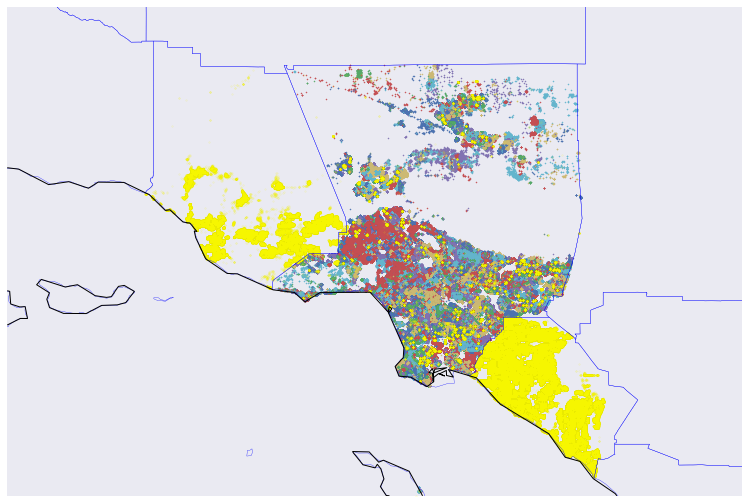

In [61]:
view_map( df_new, 'propertyzoningdesc',see_unknown=True, ignorefirst = False )

In [62]:
df_la=df_new[df_new['regionidcounty']==3101]

In [76]:
df_la['propertyzoning_cat']=pd.factorize(df_la['propertyzoningdesc'])[0]+1

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
df_la['propertyzoning_cat']

0             0
1             1
2             2
3             2
4             3
5             4
6             2
7             5
8             6
9             7
10            2
11            8
12            9
13           10
14           11
15           12
16           13
17           14
18           15
19           16
20            2
21           17
22           18
23           19
24           20
25           21
26           22
27           23
28           24
29           25
           ... 
2973714     565
2973715      25
2973716      13
2973717    2702
2973718    2131
2973719       0
2973733      90
2973734      21
2973736      27
2973737     341
2973738      40
2973739       0
2973740    1086
2973742     216
2973743     155
2973744    1086
2973745    1068
2973758     371
2973759    1086
2973760     327
2973761       4
2973762      25
2973764     307
2973766     851
2973774     277
2973775       9
2973776    1521
2973777    2133
2973778    1068
2973779      33
Name: propertyzoning_cat

In [23]:
df_la=fillna_knn( df = df_la,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertyzoning_cat', fraction = 0.15 )

fitting


MemoryError: 

In [79]:
df_la.to_pickle('df_la')

In [80]:
df_new['propertycountylandusecode'].value_counts()

0100    1153896
122      522145
0101     247494
010C     225410
1111     126491
34       123249
0200     104612
010D      60503
1         60167
010E      50978
1110      38363
0300      35926
0400      32821
1129      31391
070P      23763
0104      13988
1210      10356
1118       9677
0          9501
1128       9421
73         8570
012C       8172
01DC       6407
96         5684
38         4954
71         4117
0103       3501
1200       3299
0109       3165
010V       3019
         ...   
030B          1
0231          1
2700          1
030L          1
4400          1
0141          1
1723          1
1002          1
0741          1
04TO          1
0134          1
0450          1
121*          1
01C           1
070V          1
0122          1
103           1
0711          1
07M           1
03TO          1
7200          1
1181          1
0308          1
1724          1
02G0          1
9100          1
3414          1
020A          1
2003          1
01T0          1
Name: propertycountyland

num groups:   240
840 missing value at column: propertycountylandusecode


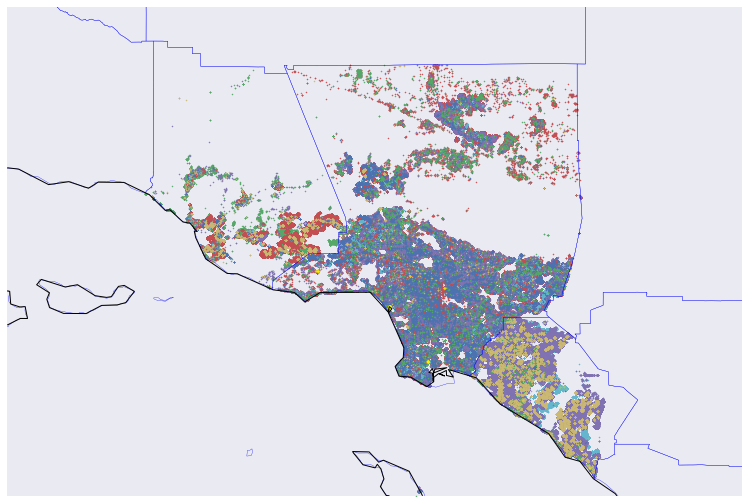

In [81]:
view_map( df_new, 'propertycountylandusecode',see_unknown=True, ignorefirst = False )

In [13]:
df_new['propertycountylandusecode_cat']=pd.factorize(df_new['propertycountylandusecode'])[0]

In [14]:
df_new.loc[119]

latitude                                  33.9843
longitude                                -118.453
propertycountylandusecode                     NaN
propertylandusetypeid                         266
propertyzoningdesc                            NaN
regionidcity                                53162
regionidcounty                               3101
regionidneighborhood                          nan
regionidzip                                 96128
censustractandblock                           NaN
rawcensustractandblock           060377029.014003
fips                                         6037
propertycountylandusecode_cat                  -1
Name: 119, dtype: object

In [15]:
df_new.loc[df_new['propertycountylandusecode_cat']<0, 'propertycountylandusecode_cat'] = np.nan

In [16]:
df_new=fillna_knn( df = df_new,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertycountylandusecode_cat', fraction = 0.30 )

fitting
the shape of active features:  (176,)
perdicting
writing result to df_new
num of unperdictable data:  1.0


In [24]:
gc.collect()

86

In [22]:
df_la = pd.read_pickle('df_la')

In [25]:
missingcount = df_new.isnull().sum(axis=0)
missingcount[missingcount>0]

propertycountylandusecode        840
propertyzoningdesc            995151
regionidneighborhood         1799189
regionidzip                     2328
censustractandblock            63689
dtype: int64

# Wrap up

In [7]:
geocolumns = [ 'parcelid' ,'latitude', 'longitude'
                            ,'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc'
                            ,'regionidcity','regionidcounty', 'regionidneighborhood', 'regionidzip'
                            ,'censustractandblock', 'rawcensustractandblock', 'fips']
geoprop = prop[geocolumns]
parcelid = prop.parcelid
del prop; gc.collect()
geoprop.dropna( axis = 0, subset = [ 'latitude', 'longitude' ], inplace = True )
geoprop.loc[:,'latitude'] = geoprop.loc[:,'latitude']/1e6
geoprop.loc[:,'longitude'] = geoprop.loc[:,'longitude']/1e6

In [35]:
missingcount = geoprop.isnull().sum(axis=0)
missingcount[missingcount>0]

propertycountylandusecode        840
propertyzoningdesc            995151
regionidcity                   50950
regionidneighborhood         1799189
regionidzip                     2328
censustractandblock            63689
dtype: int64

In [8]:
def create_catagory(df, name):
    df[name+'_cat']=pd.factorize(df[name])[0]
    df.loc[df[name+'_cat']<0, name+'_cat'] = np.nan
    return df

In [9]:
def add_census_block_feature(df):
    df2 = df.rawcensustractandblock.str.extract('(?P<fips_census_1>\d{9})\.(?P<block_1>\d*)')
    df2['fips_census_block'] = df2['fips_census_1'] + df2['block_1']
    return pd.concat([df, df2], axis=1)

In [10]:
from sklearn import neighbors
from sklearn.preprocessing import OneHotEncoder

def fillna_knn_inplace( df, base, target, fraction = 1, threshold = 10 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base # [regionidcity, lat, lon]
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print( 'fitting' )
    n_neighbors = 5
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    print( 'the shape of active features: ' ,enc.active_features_.shape )
    
    print( 'perdicting' )
    Z = clf.predict(df.loc[ miss, base  ])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        print( 'writing result to df' )
        df.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        print( 'num of unperdictable data: ', numunperdicted )
    else:
        print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )

In [11]:
fillna_knn_inplace( df = geoprop,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcity', fraction = 0.15 )
fillna_knn_inplace( df = geoprop,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidzip', fraction = 0.15 )
geoprop = create_catagory(geoprop, 'propertycountylandusecode')
fillna_knn_inplace( df = geoprop,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertycountylandusecode_cat', fraction = 0.30 )
geoprop = add_census_block_feature(geoprop)

fitting
the shape of active features:  (183,)
perdicting
writing result to df
num of unperdictable data:  72.0
fitting
the shape of active features:  (394,)
perdicting
writing result to df
num of unperdictable data:  3.0
fitting
the shape of active features:  (188,)
perdicting
writing result to df
num of unperdictable data:  1.0


/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [12]:
missingcount = geoprop.isnull().sum(axis=0)
missingcount[missingcount>0]

propertycountylandusecode        840
propertyzoningdesc            995151
regionidneighborhood         1799189
censustractandblock            63689
dtype: int64

In [14]:
geoprop[['regionidcity', 'regionidcounty', 'regionidzip', 'propertycountylandusecode_cat', 'fips_census_1', 'block_1', 'fips_census_block']]

,regionidcity,regionidcounty,regionidzip,propertycountylandusecode_cat,fips_census_1,block_1,fips_census_block
0,37688.0,3101.0,96337.0,0.0,060378002,0410,0603780020410
1,37688.0,3101.0,96337.0,1.0,060378001,011002,060378001011002
2,51617.0,3101.0,96095.0,2.0,060377030,012017,060377030012017
3,12447.0,3101.0,96424.0,2.0,060371412,023001,060371412023001
4,12447.0,3101.0,96450.0,3.0,060371232,052003,060371232052003
5,12447.0,3101.0,96446.0,3.0,060371252,001000,060371252001000
6,12447.0,3101.0,96049.0,4.0,060371437,00101,06037143700101
7,396054.0,3101.0,96434.0,3.0,060373108,003004,060373108003004
8,396054.0,3101.0,96436.0,0.0,060373101,003001,060373101003001
9,47547.0,3101.0,96366.0,3.0,060373202,023005,060373202023005


In [54]:
geoprop = pd.merge(pd.DataFrame(parcelid), geoprop, how='outer', on = 'parcelid')

In [57]:
geoprop[['parcelid', 'latitude', 'longitude']]

,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,censustractandblock,rawcensustractandblock,fips
0,010D,269.0,NaN,37688.0,3101.0,NaN,96337.0,NaN,060378002.0410,6037.0
1,0109,261.0,LCA11*,37688.0,3101.0,NaN,96337.0,NaN,060378001.011002,6037.0
2,1200,47.0,LAC2,51617.0,3101.0,NaN,96095.0,NaN,060377030.012017,6037.0
3,1200,47.0,LAC2,12447.0,3101.0,27080.0,96424.0,NaN,060371412.023001,6037.0
4,1210,31.0,LAM1,12447.0,3101.0,46795.0,96450.0,NaN,060371232.052003,6037.0
5,1210,31.0,LAC4,12447.0,3101.0,46795.0,96446.0,NaN,060371252.001000,6037.0
6,010V,260.0,LAC2,12447.0,3101.0,274049.0,96049.0,NaN,060371437.00101,6037.0
7,1210,31.0,BUC4YY,396054.0,3101.0,NaN,96434.0,NaN,060373108.003004,6037.0
8,010D,269.0,BUR1*,396054.0,3101.0,NaN,96436.0,NaN,060373101.003001,6037.0
9,1210,31.0,SFC2*,47547.0,3101.0,NaN,96366.0,NaN,060373202.023005,6037.0
